<a href="https://colab.research.google.com/github/takumi19910112/google_colab/blob/main/yama_3_xg_boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
####################################
# Library
####################################
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import math
import time
import random
import string
import psutil
import pathlib
import datetime
from pathlib import Path
from contextlib import contextmanager
from pprint import pprint
from types import SimpleNamespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, train_test_split

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"xgboost.__version__: {xgb.__version__}")

tokenizers.__version__: 0.21.0
xgboost.__version__: 2.1.4


In [18]:
config = SimpleNamespace()

config.exp_name = '001-exp-xgboost'
config.exp_comment = 'xgboost_baseline'
config.seed = 42
config.n_fold = 5
config.num_classes = 3
# XGBoostのMODELパラメータの設定
config.xgb_params = {
    'objective': 'multiclass',
    'num_class': config.num_classes,
    'learning_rate': 0.1,
    'n_estimators': 2000,
    'verbosity': 1,
}
config.eval_rounds = 100
config.stopping_rounds = 200

pprint(config)

namespace(exp_name='001-exp-xgboost',
          exp_comment='xgboost_baseline',
          seed=42,
          n_fold=5,
          num_classes=3,
          xgb_params={'learning_rate': 0.1,
                      'n_estimators': 2000,
                      'num_class': 3,
                      'objective': 'multiclass',
                      'verbosity': 1},
          eval_rounds=100,
          stopping_rounds=200)


In [3]:
OUTPUT_DIR = Path(f'./{config.exp_name}')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'OUTPUT_DIR: {OUTPUT_DIR}')

OUTPUT_DIR: 001-exp-xgboost


In [4]:
## 再現性確保のためのSeed固定
def seed_everything(seed:int==42):

    """pythonとosのseedを固定

    Args:
        seed (int, optional): 固定したいseed値. Defaults to =42.
    """

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed)

# 2. Dataのロード

In [6]:
with timer('data load'):

    train_df = pd.read_csv("/content/drive/MyDrive/m_learn/train.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/m_learn/test.csv")
    sub_df = pd.read_csv("/content/drive/MyDrive/m_learn/sample_submission.csv")

    print(f'train: {train_df.shape}')
    print(f'test: {test_df.shape}')
    print(f'sub: {sub_df.shape}')

<< data load >> Start
train: (1233, 3)
test: (828, 3)
sub: (828, 2)
<< data load >> 0.6GB(+0.0GB):1.5sec


In [59]:
print(f'train: {train_df}')

train:                                                  prompt  \
0     ### Postgres SQL tables, with their properties...   
1     ### Postgres SQL tables, with their properties...   
2     ### Postgres SQL tables, with their properties...   
3     **Q**\nIs the following sentence factually cor...   
4     **Q**\nIs the following sentence factually cor...   
...                                                 ...   
1230  write me some python code to pull down docker ...   
1231  write me some python code to pull down docker ...   
1232  𝐝𝐞𝐟 𝐜𝐚𝐥𝐜(𝐚𝐫𝐫: int = [3]) -> list:\n 𝐫𝐞𝐭𝐮𝐫𝐧 𝐚𝐫𝐫...   
1233  𝐝𝐞𝐟 𝐜𝐚𝐥𝐜(𝐚𝐫𝐫: int = [3]) -> list:\n 𝐫𝐞𝐭𝐮𝐫𝐧 𝐚𝐫𝐫...   
1234  𝐝𝐞𝐟 𝐜𝐚𝐥𝐜(𝐚𝐫𝐫: int = [3]) -> list:\n 𝐫𝐞𝐭𝐮𝐫𝐧 𝐚𝐫𝐫...   

                                                   text  label  \
0     To list the names of departments that employed...      0   
1     To list the names of the departments which emp...      1   
2     ```\nSELECT d.name\nFROM Department d\nJOIN Em...      2   
3                   

In [7]:
# 文字数
train_df['num_characters_text'] = train_df['text'].apply(lambda x: len(x))
test_df['num_characters_text'] = test_df['text'].apply(lambda x: len(x))

# promptの文字数に対するtextの文字数の比
train_df['num_characters_prompt'] = train_df['prompt'].apply(lambda x: len(x))
test_df['num_characters_prompt'] = test_df['prompt'].apply(lambda x: len(x))

train_df['num_characters_ratio'] = train_df['num_characters_text'] / train_df['num_characters_prompt']
test_df['num_characters_ratio'] = test_df['num_characters_text'] / test_df['num_characters_prompt']
train_df

,prompt,text,label,num_characters_text,num_characters_prompt,num_characters_ratio
0,"### Postgres SQL tables, with their properties...",To list the names of departments that employed...,0,381,279,1.365591
1,"### Postgres SQL tables, with their properties...",To list the names of the departments which emp...,1,990,279,3.548387
2,"### Postgres SQL tables, with their properties...",```\nSELECT d.name\nFROM Department d\nJOIN Em...,2,243,279,0.870968
3,**Q**\nIs the following sentence factually cor...,yes,0,3,716,0.004190
4,**Q**\nIs the following sentence factually cor...,"**Q**\nClaim: ""Matthew Shepard died in Laramie...",1,466,716,0.650838
...,...,...,...,...,...,...
1228,write me some python code to pull down docker ...,Here's a simple Python script that can pull do...,1,1198,76,15.763158
1229,write me some python code to pull down docker ...,```python\nimport docker\n\n# Create a Docker ...,2,372,76,4.894737
1230,𝐝𝐞𝐟 𝐜𝐚𝐥𝐜(𝐚𝐫𝐫: int = [3]) -> list:\n 𝐫𝐞𝐭𝐮𝐫𝐧 𝐚𝐫𝐫...,This function named def_calc takes one argumen...,0,574,105,5.466667
1231,𝐝𝐞𝐟 𝐜𝐚𝐥𝐜(𝐚𝐫𝐫: int = [3]) -> list:\n 𝐫𝐞𝐭𝐮𝐫𝐧 𝐚𝐫𝐫...,Certainly! Here's a detailed docstring for the...,1,907,105,8.638095


In [8]:
# 単語数
# textの単語数
train_df['word_split_text'] = train_df['text'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
train_df['num_words_text'] = train_df['word_split_text'].apply(lambda x: len(x)) # 単語数
test_df['word_split_text'] = test_df['text'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
test_df['num_words_text'] = test_df['word_split_text'].apply(lambda x: len(x)) # 単語数
# promptの単語数
train_df['word_split_prompt'] = train_df['prompt'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
train_df['num_words_prompt'] = train_df['word_split_prompt'].apply(lambda x: len(x)) # 単語数
test_df['word_split_prompt'] = test_df['prompt'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
test_df['num_words_prompt'] = test_df['word_split_prompt'].apply(lambda x: len(x)) # 単語数

# textの単語数とpromptの単語数の比
train_df['num_words_ratio'] = train_df['num_words_text'] / train_df['num_words_prompt']
test_df['num_words_ratio'] = test_df['num_words_text'] / train_df['num_words_prompt']


In [9]:
# textの文章数
train_df['sentence_split_text'] = train_df['text'].apply(lambda x: x.lower().split('.')) # 小文字にしてから単語で分割
train_df['num_sentence_text'] = train_df['sentence_split_text'].apply(lambda x: len(x)) # 単語数
test_df['sentence_split_text'] = test_df['text'].apply(lambda x: x.lower().split('.')) # 小文字にしてから単語で分割
test_df['num_sentence_text'] = test_df['sentence_split_text'].apply(lambda x: len(x)) # 単語数
# promptの単語数
train_df['sentence_split_prompt'] = train_df['prompt'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
train_df['num_sentence_prompt'] = train_df['sentence_split_prompt'].apply(lambda x: len(x)) # 単語数
test_df['sentence_split_prompt'] = test_df['prompt'].apply(lambda x: x.lower().split(' ')) # 小文字にしてから単語で分割
test_df['num_sentence_prompt'] = test_df['sentence_split_prompt'].apply(lambda x: len(x)) # 単語数
# textの単語数とpromptの単語数の比
train_df['num_sentence_ratio'] = train_df['num_sentence_text'] / train_df['num_sentence_prompt']
test_df['num_sentence_ratio'] = test_df['num_sentence_text'] / test_df['num_sentence_prompt']

In [10]:
# promptごとのtextの文字数を集計　→ 特徴量として追加
tmp = train_df.groupby('prompt')['num_characters_text'].agg(['mean', 'max', 'min'])
tmp = tmp.add_prefix('num_characters_text_')
display(tmp.head())

train_df = pd.merge(
    train_df,
    tmp,
    on='prompt',
    how='left'
)
tmp = test_df.groupby('prompt')['num_characters_text'].agg(['mean', 'max', 'min'])
tmp = tmp.add_prefix('num_characters_text_')
display(tmp.head())

test_df = pd.merge(
    test_df,
    tmp,
    on='prompt',
    how='left'
)

num_characters_text_mean  \
prompt                                                                         
### Postgres SQL tables, with their properties:...                538.000000   
**Q**\nIs the following sentence factually corr...                219.000000   
30 students from 5 classes solved 40 math probl...                683.666667   
9616 x 46882?\nOnly mathematical symbols, no ve...                 19.000000   
:\nYou have been given a code snippet that appe...               1218.666667   

                                                    num_characters_text_max  \
prompt                                                                        
### Postgres SQL tables, with their properties:...                      990   
**Q**\nIs the following sentence factually corr...                      466   
30 students from 5 classes solved 40 math probl...                     1080   
9616 x 46882?\nOnly mathematical symbols, no ve...                       26   
:\nYou have been given a code snippet that appe...                     2492   

                                                    num_characters_text_min  
prompt                                                                       
### Postgres SQL tables, with their properties:...                      243  
**Q**\nIs the following sentence factually corr...                        3  
30 students from 5 classes solved 40 math probl...                        2  
9616 x 46882?\nOnly mathematical symbols, no ve...                       11  
:\nYou have been given a code snippet that appe...                      452

,num_characters_text_mean,num_characters_text_max,num_characters_text_min
prompt,,,
"10 positive reasons to move a warehouse facility from Ontario, CA to Las Vegas Nevada.",1419.333333,1761,788
542322 * 3945?\nExclude words; show only the math.,16.333333,26,10
":\n\nYou are given a code snippet that is part of a web application for an online course platform. The snippet is responsible for displaying the number of courses found based on the user type.\n\nThe snippet consists of HTML and embedded PHP code. The PHP code is responsible for determining the number of courses found and the appropriate pluralization of the word ""Course"".\n\nYour task is to write a function that takes in the user type count and course count as input and returns the generated HTML code snippet as a string.\n\nImplement the following function:\n\n```python\ndef generate_course_html(user_type_count: int, course_count: int) -> str:\n pass\n```\n\n**Input:**\n\nThe function takes in two integers:\n- `user_type_count` (1 <= user_type_count <= 100): the number of user types (e.g., instructors, students, etc.).\n- `course_count` (0 <= course_count <= 100): the number of courses found.\n\n**Output:**\n\n- Returns a string containing the HTML code snippet with the appropriate values for `$coursecount` and `$usertypecount`.\n\n**Note:**\n- You may assume that `str_plural` is a custom function already provided, which takes a string as input and returns its pluralized form.\n- The `fa fa-fw fa-book` class is used to display a book icon.",867.666667,1264,410
Adapt the following sentence for the social media post:\nRegular exercise can help maintain a healthy lifestyle.,212.666667,429,98
"Analyze the text below for style, voice, and tone. Using NLP, create a prompt to write a new article in the same style, voice, and tone: Bolsonaro supporters generate chaos in Brasilia, Brazil, with the invasion of the Supreme Court, National Congress and the Planalto Palace on Sunday, January 8. Mateus Bonomi/Anadolu Agency/Getty Images",711.666667,1048,503


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [11]:
# TF-IDFによる特徴量作成
vec = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    analyzer='word',
    ngram_range=(1, 2),
)
train_tfidf = vec.fit_transform([i for i in train_df['text']])
test_tfidf = vec.transform([i for i in test_df['text']])

In [12]:
# train
train_dense_matrix = train_tfidf.toarray()
train_tfidf_df = pd.DataFrame(train_dense_matrix)
train_tfidf_df.columns = [f'tfidf_{i}' for i in range(len(train_tfidf_df.columns))]
train_tfidf_df['text'] = train_df['text']
train_df = pd.merge(
    train_df,
    train_tfidf_df,
    on='text',
    how='left'
)

In [13]:
# test
test_dense_matrix = test_tfidf.toarray()
test_tfidf_df = pd.DataFrame(test_dense_matrix)
test_tfidf_df.columns = [f'tfidf_{i}' for i in range(len(test_tfidf_df.columns))]
test_tfidf_df['text'] = test_df['text']
test_df = pd.merge(
    test_df,
    test_tfidf_df,
    on='text',
    how='left'
)

In [14]:
# feature columns & target column
feature_columns = train_df.select_dtypes('number').columns
feature_columns = [c for c in feature_columns if c != 'label']

target_column = 'label'

print(f'features: {len(feature_columns):,}')

features: 4,830


In [15]:
train_df['fold'] = -1
skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

for fold, (_, va_idx) in enumerate(skf.split(train_df, train_df['label'])):

    train_df.loc[va_idx, 'fold'] = fold+1

train_df['fold'] = train_df['fold'].astype('int')

pd.pivot_table(train_df, index='fold', columns='label', values='prompt', aggfunc='count')

label,0,1,2
fold,,,
1,83,82,82
2,82,83,82
3,82,82,83
4,82,82,83
5,82,82,83


# 4.Training

In [16]:
def f1(y_true, y_pred):
    N_LABELS = 3
    y_pred_ = y_pred.argmax(axis=1)
    score = f1_score(y_true, y_pred_, average='macro')
    return 'f1', score, True

oof_prob = np.zeros((len(train_df), config.num_classes))
imp_dfs = []

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 3値分類の混同行列を表示する関数
def plot_confusion_matrix_3class(y_true, y_pred, title='3-Class Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    return cm

# 2値分類の混同行列を表示する関数
def plot_confusion_matrix_binary(y_true, y_pred, title='Binary Confusion Matrix'):
    # 2値分類の場合のラベル
    labels = ['Class 0', 'Other Classes']

    # 混同行列の計算
    # y_trueを2値に変換（0かそれ以外か）
    y_true_binary = [0 if y == 0 else 1 for y in y_true]
    y_pred_binary = [0 if y == 0 else 1 for y in y_pred]

    cm = confusion_matrix(y_true_binary, y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    return cm

★★★★ fold 1 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99191	validation_1-mlogloss:1.02806
[1]	validation_0-mlogloss:0.89945	validation_1-mlogloss:0.96892
[2]	validation_0-mlogloss:0.81919	validation_1-mlogloss:0.91726
[3]	validation_0-mlogloss:0.74964	validation_1-mlogloss:0.87605
[4]	validation_0-mlogloss:0.68868	validation_1-mlogloss:0.84040
[5]	validation_0-mlogloss:0.63469	validation_1-mlogloss:0.80847
[6]	validation_0-mlogloss:0.58613	validation_1-mlogloss:0.78145
[7]	validation_0-mlogloss:0.54323	validation_1-mlogloss:0.75928
[8]	validation_0-mlogloss:0.50456	validation_1-mlogloss:0.73651
[9]	validation_0-mlogloss:0.46793	validation_1-mlogloss:0.71896
[10]	validation_0-mlogloss:0.43599	validation_1-mlogloss:0.70060
[11]	validation_0-mlogloss:0.40693	validation_1-mlogloss:0.68552
[12]	validation_0-mlogloss:0.37916	validation_1-mlogloss:0.67203
[13]	validation_0-mlogloss:0.35487	validation_1-mlogloss:0.65936
[14]	validation_0-mlogloss:0.33168	validation_1-mlogloss

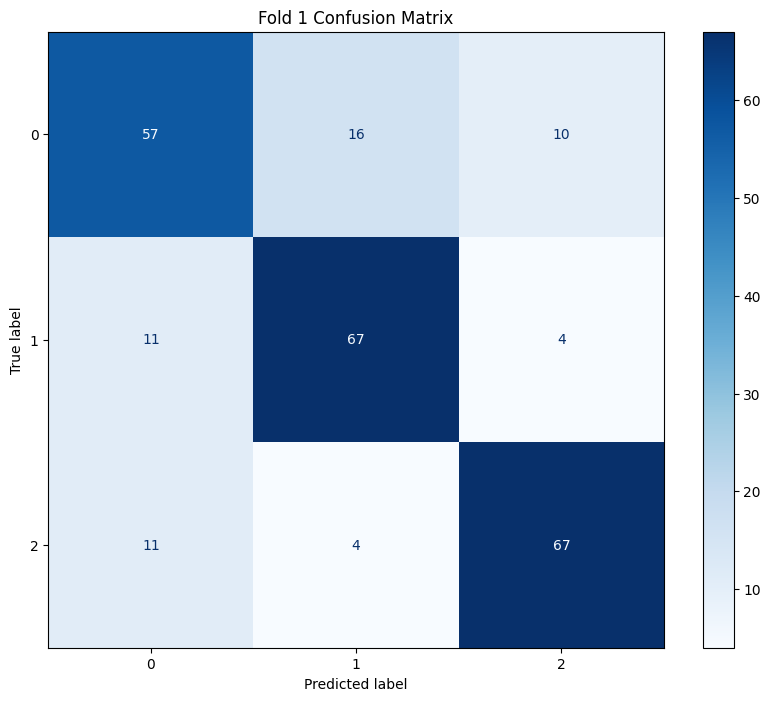

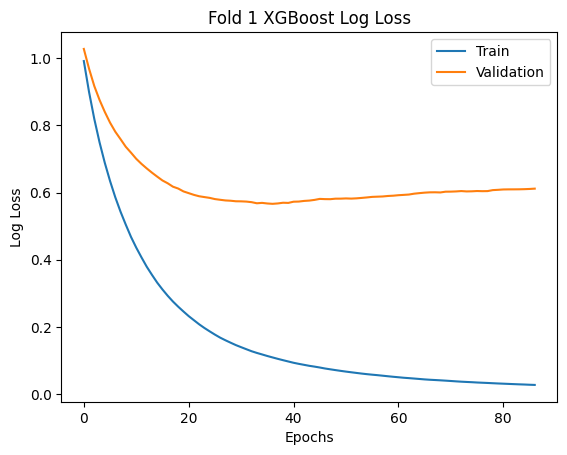

★★★★ fold 2 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99368	validation_1-mlogloss:1.02804
[1]	validation_0-mlogloss:0.90400	validation_1-mlogloss:0.97113
[2]	validation_0-mlogloss:0.82574	validation_1-mlogloss:0.92220
[3]	validation_0-mlogloss:0.75716	validation_1-mlogloss:0.87784
[4]	validation_0-mlogloss:0.69630	validation_1-mlogloss:0.83920
[5]	validation_0-mlogloss:0.64267	validation_1-mlogloss:0.80549
[6]	validation_0-mlogloss:0.59378	validation_1-mlogloss:0.77441
[7]	validation_0-mlogloss:0.55007	validation_1-mlogloss:0.74902
[8]	validation_0-mlogloss:0.51095	validation_1-mlogloss:0.72689
[9]	validation_0-mlogloss:0.47566	validation_1-mlogloss:0.70749
[10]	validation_0-mlogloss:0.44309	validation_1-mlogloss:0.68973
[11]	validation_0-mlogloss:0.41268	validation_1-mlogloss:0.67213
[12]	validation_0-mlogloss:0.38532	validation_1-mlogloss:0.65704
[13]	validation_0-mlogloss:0.36022	validation_1-mlogloss:0.64481
[14]	validation_0-mlogloss:0.33650	validation_1-mlogloss

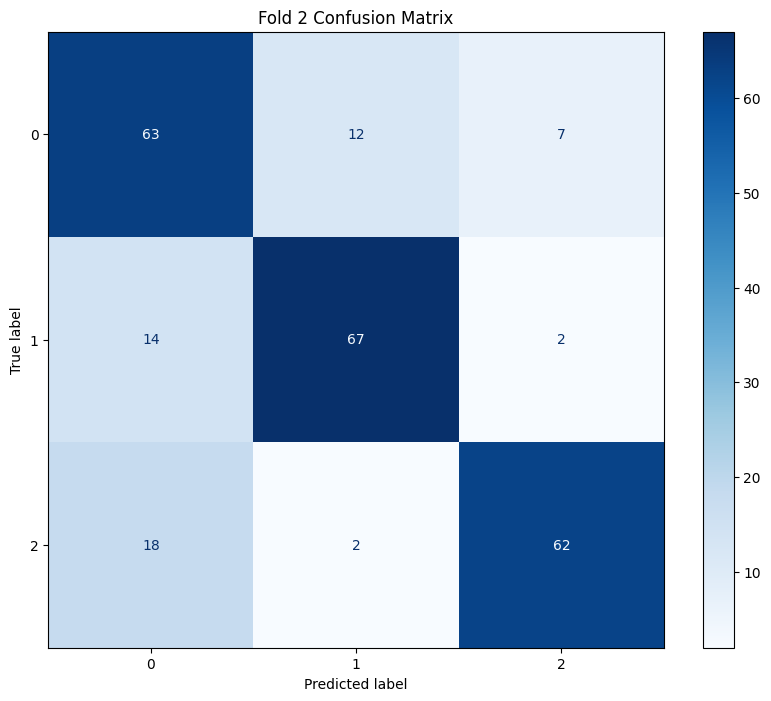

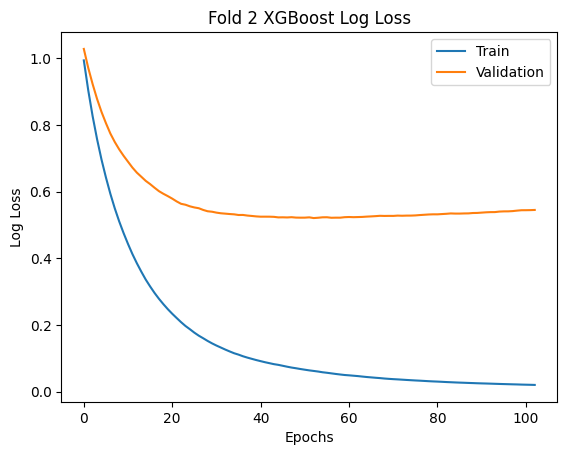

★★★★ fold 3 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99685	validation_1-mlogloss:1.02818
[1]	validation_0-mlogloss:0.90906	validation_1-mlogloss:0.96521
[2]	validation_0-mlogloss:0.83243	validation_1-mlogloss:0.91065
[3]	validation_0-mlogloss:0.76531	validation_1-mlogloss:0.86315
[4]	validation_0-mlogloss:0.70699	validation_1-mlogloss:0.82083
[5]	validation_0-mlogloss:0.65427	validation_1-mlogloss:0.78750
[6]	validation_0-mlogloss:0.60519	validation_1-mlogloss:0.75801
[7]	validation_0-mlogloss:0.56164	validation_1-mlogloss:0.72896
[8]	validation_0-mlogloss:0.52235	validation_1-mlogloss:0.70578
[9]	validation_0-mlogloss:0.48687	validation_1-mlogloss:0.68556
[10]	validation_0-mlogloss:0.45358	validation_1-mlogloss:0.66636
[11]	validation_0-mlogloss:0.42399	validation_1-mlogloss:0.64932
[12]	validation_0-mlogloss:0.39697	validation_1-mlogloss:0.63239
[13]	validation_0-mlogloss:0.37252	validation_1-mlogloss:0.61934
[14]	validation_0-mlogloss:0.34950	validation_1-mlogloss

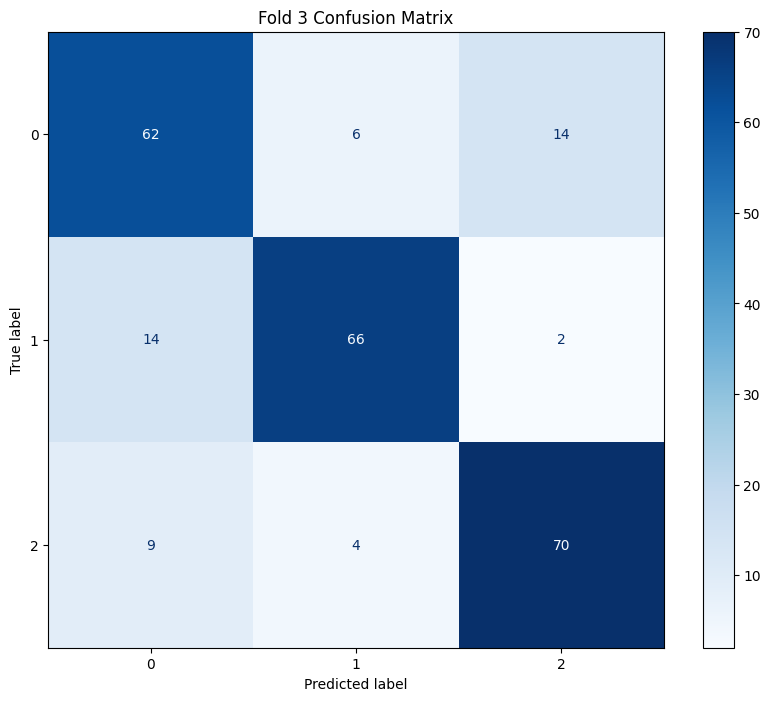

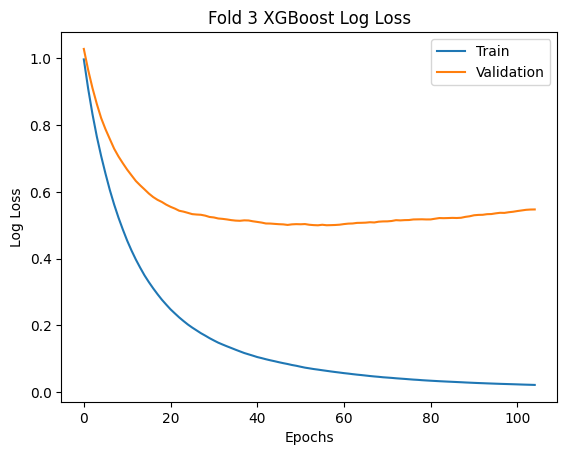

★★★★ fold 4 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99630	validation_1-mlogloss:1.03015
[1]	validation_0-mlogloss:0.90900	validation_1-mlogloss:0.97209
[2]	validation_0-mlogloss:0.83501	validation_1-mlogloss:0.92153
[3]	validation_0-mlogloss:0.76913	validation_1-mlogloss:0.87833
[4]	validation_0-mlogloss:0.70734	validation_1-mlogloss:0.83700
[5]	validation_0-mlogloss:0.65344	validation_1-mlogloss:0.79943
[6]	validation_0-mlogloss:0.60398	validation_1-mlogloss:0.76566
[7]	validation_0-mlogloss:0.55943	validation_1-mlogloss:0.73807
[8]	validation_0-mlogloss:0.51979	validation_1-mlogloss:0.71123
[9]	validation_0-mlogloss:0.48417	validation_1-mlogloss:0.69094
[10]	validation_0-mlogloss:0.45052	validation_1-mlogloss:0.67001
[11]	validation_0-mlogloss:0.42117	validation_1-mlogloss:0.65367
[12]	validation_0-mlogloss:0.39267	validation_1-mlogloss:0.63869
[13]	validation_0-mlogloss:0.36763	validation_1-mlogloss:0.62433
[14]	validation_0-mlogloss:0.34473	validation_1-mlogloss

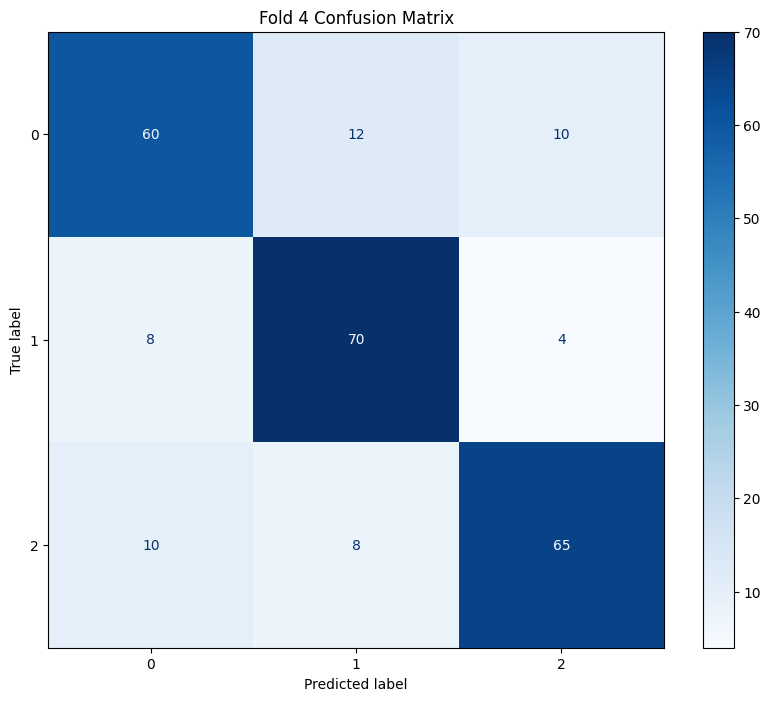

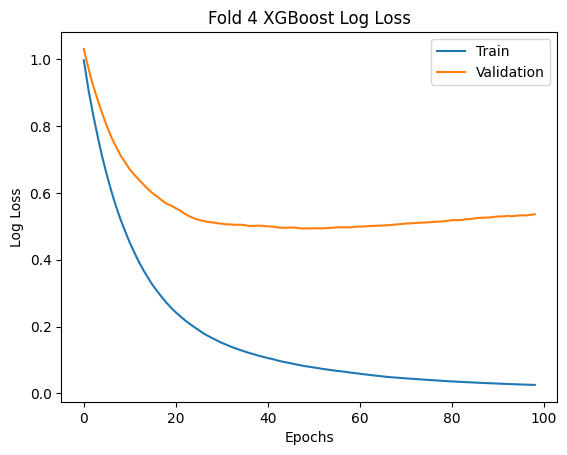

★★★★ fold 5 ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-mlogloss:0.99511	validation_1-mlogloss:1.02298
[1]	validation_0-mlogloss:0.90593	validation_1-mlogloss:0.96074
[2]	validation_0-mlogloss:0.82726	validation_1-mlogloss:0.90980
[3]	validation_0-mlogloss:0.76100	validation_1-mlogloss:0.86532
[4]	validation_0-mlogloss:0.70154	validation_1-mlogloss:0.82674
[5]	validation_0-mlogloss:0.64759	validation_1-mlogloss:0.78876
[6]	validation_0-mlogloss:0.59692	validation_1-mlogloss:0.75796
[7]	validation_0-mlogloss:0.55345	validation_1-mlogloss:0.72854
[8]	validation_0-mlogloss:0.51437	validation_1-mlogloss:0.70620
[9]	validation_0-mlogloss:0.47826	validation_1-mlogloss:0.68083
[10]	validation_0-mlogloss:0.44590	validation_1-mlogloss:0.66176
[11]	validation_0-mlogloss:0.41526	validation_1-mlogloss:0.64371
[12]	validation_0-mlogloss:0.38691	validation_1-mlogloss:0.62865
[13]	validation_0-mlogloss:0.36192	validation_1-mlogloss:0.61564
[14]	validation_0-mlogloss:0.33818	validation_1-mlogloss

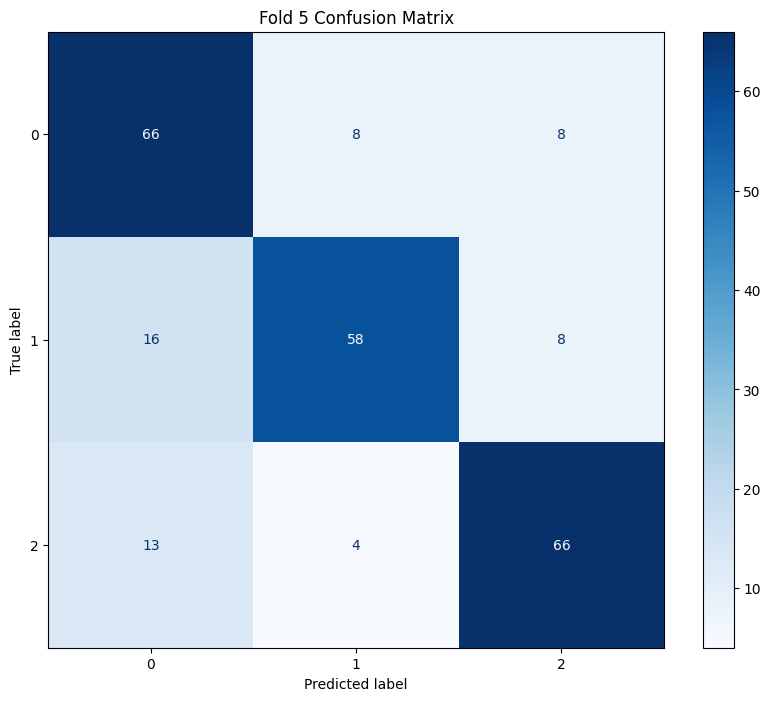

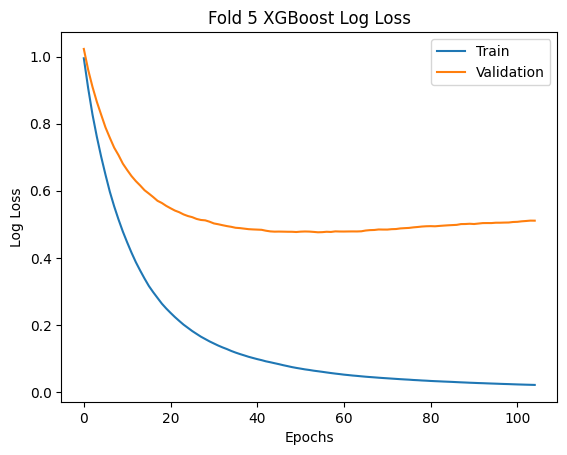

In [36]:
# クロスバリデーションのループ
for fold in range(config.n_fold):

    print(f'★★★★ fold {fold + 1} ★★★★')
    seed_everything(config.seed)

    # Train, Validation のデータ分割
    X_train = train_df.query('fold != @fold + 1').reset_index(drop=True)
    X_valid = train_df.query('fold == @fold + 1').reset_index(drop=True)
    valid_idx = train_df.query('fold == @fold + 1').index.tolist()
    print(f'X_train: {len(X_train):,}, X_valid: {len(X_valid):,}')
    y_train = X_train[target_column]
    X_train = X_train[feature_columns]

    y_valid = X_valid[target_column]
    X_valid = X_valid[feature_columns]

    # モデルの作成とコールバック
    model = XGBClassifier(
        **config.xgb_params,
        early_stopping_rounds=50
    )

    # モデルの訓練
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=True
    )

    # 予測
    # 最適なイテレーション数で予測
    pred_val = model.predict_proba(X_valid, iteration_range=(0, model.best_iteration + 1))
    pred_class = pred_val.argmax(axis=1)
    oof_prob[valid_idx] += pred_val
    valid_score = f1_score(
        y_valid,
        pred_val.argmax(axis=1),
        average='macro'
    )
    print(f"Fold {fold + 1} | Valid_score: {valid_score:.5f}")
    # 混同行列の表示
    print(f"Fold {fold + 1} の混同行列:")
    cm = plot_confusion_matrix_3class(y_valid, pred_class, title=f'Fold {fold + 1} Confusion Matrix')

    # 特徴量重要度の取得
    importances = pd.DataFrame()
    importances["feature"] = feature_columns
    importances["gain"] = model.feature_importances_
    importances["fold"] = fold + 1
    imp_dfs.append(importances)

    # モデルの保存
    model.save_model(f'./xgboost_fold_{fold + 1}.json')
    # 学習曲線
    results = model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
    ax.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title(f'Fold {fold + 1} XGBoost Log Loss')
    plt.show()

In [37]:
# CV Score
F1Score = f1_score(train_df['label'], np.argmax(oof_prob, axis=1), average='macro')
print(f'CV Score: {F1Score:.5f}')

CV Score: 0.78844


全体の混同行列:


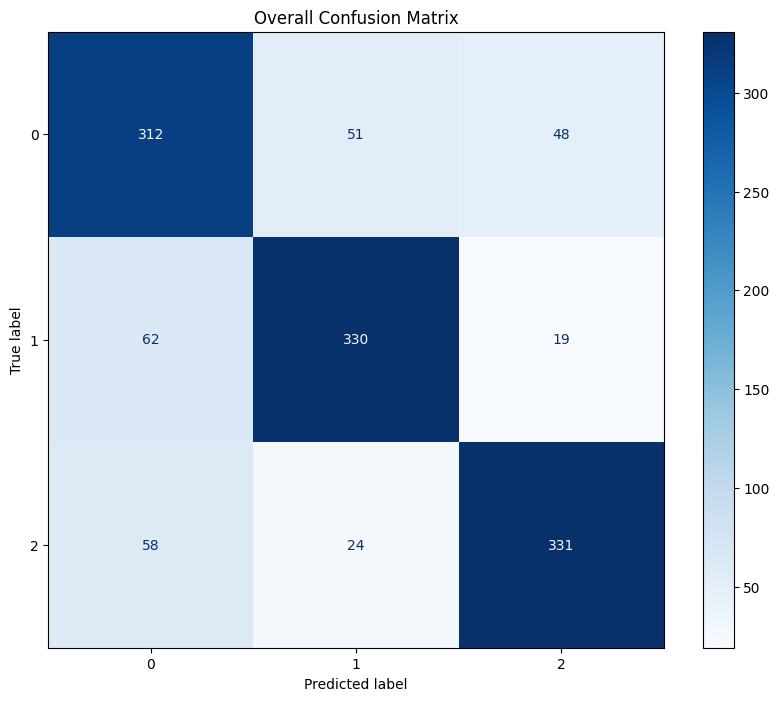

クラス 0 の精度: 0.7591
クラス 1 の精度: 0.8029
クラス 2 の精度: 0.8015


In [38]:
# 全体の予測クラスを取得
y_true = train_df[target_column]
y_pred = np.argmax(oof_prob, axis=1)

# 全体の混同行列を表示
print("全体の混同行列:")
cm_all = plot_confusion_matrix_3class(y_true, y_pred, title='Overall Confusion Matrix')

# クラスごとの精度を計算
class_accuracy = cm_all.diagonal() / cm_all.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"クラス {i} の精度: {acc:.4f}")

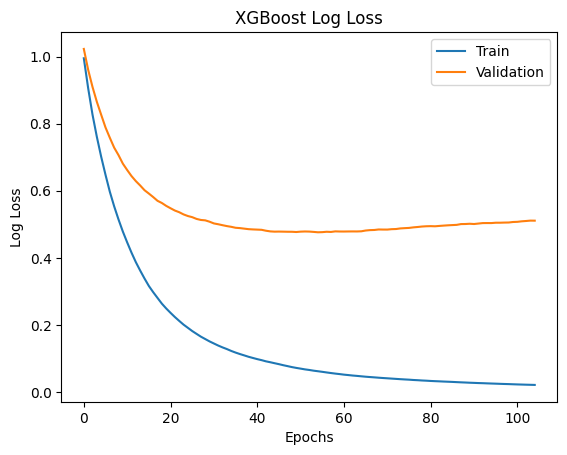

In [39]:
# 学習曲線のプロット
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

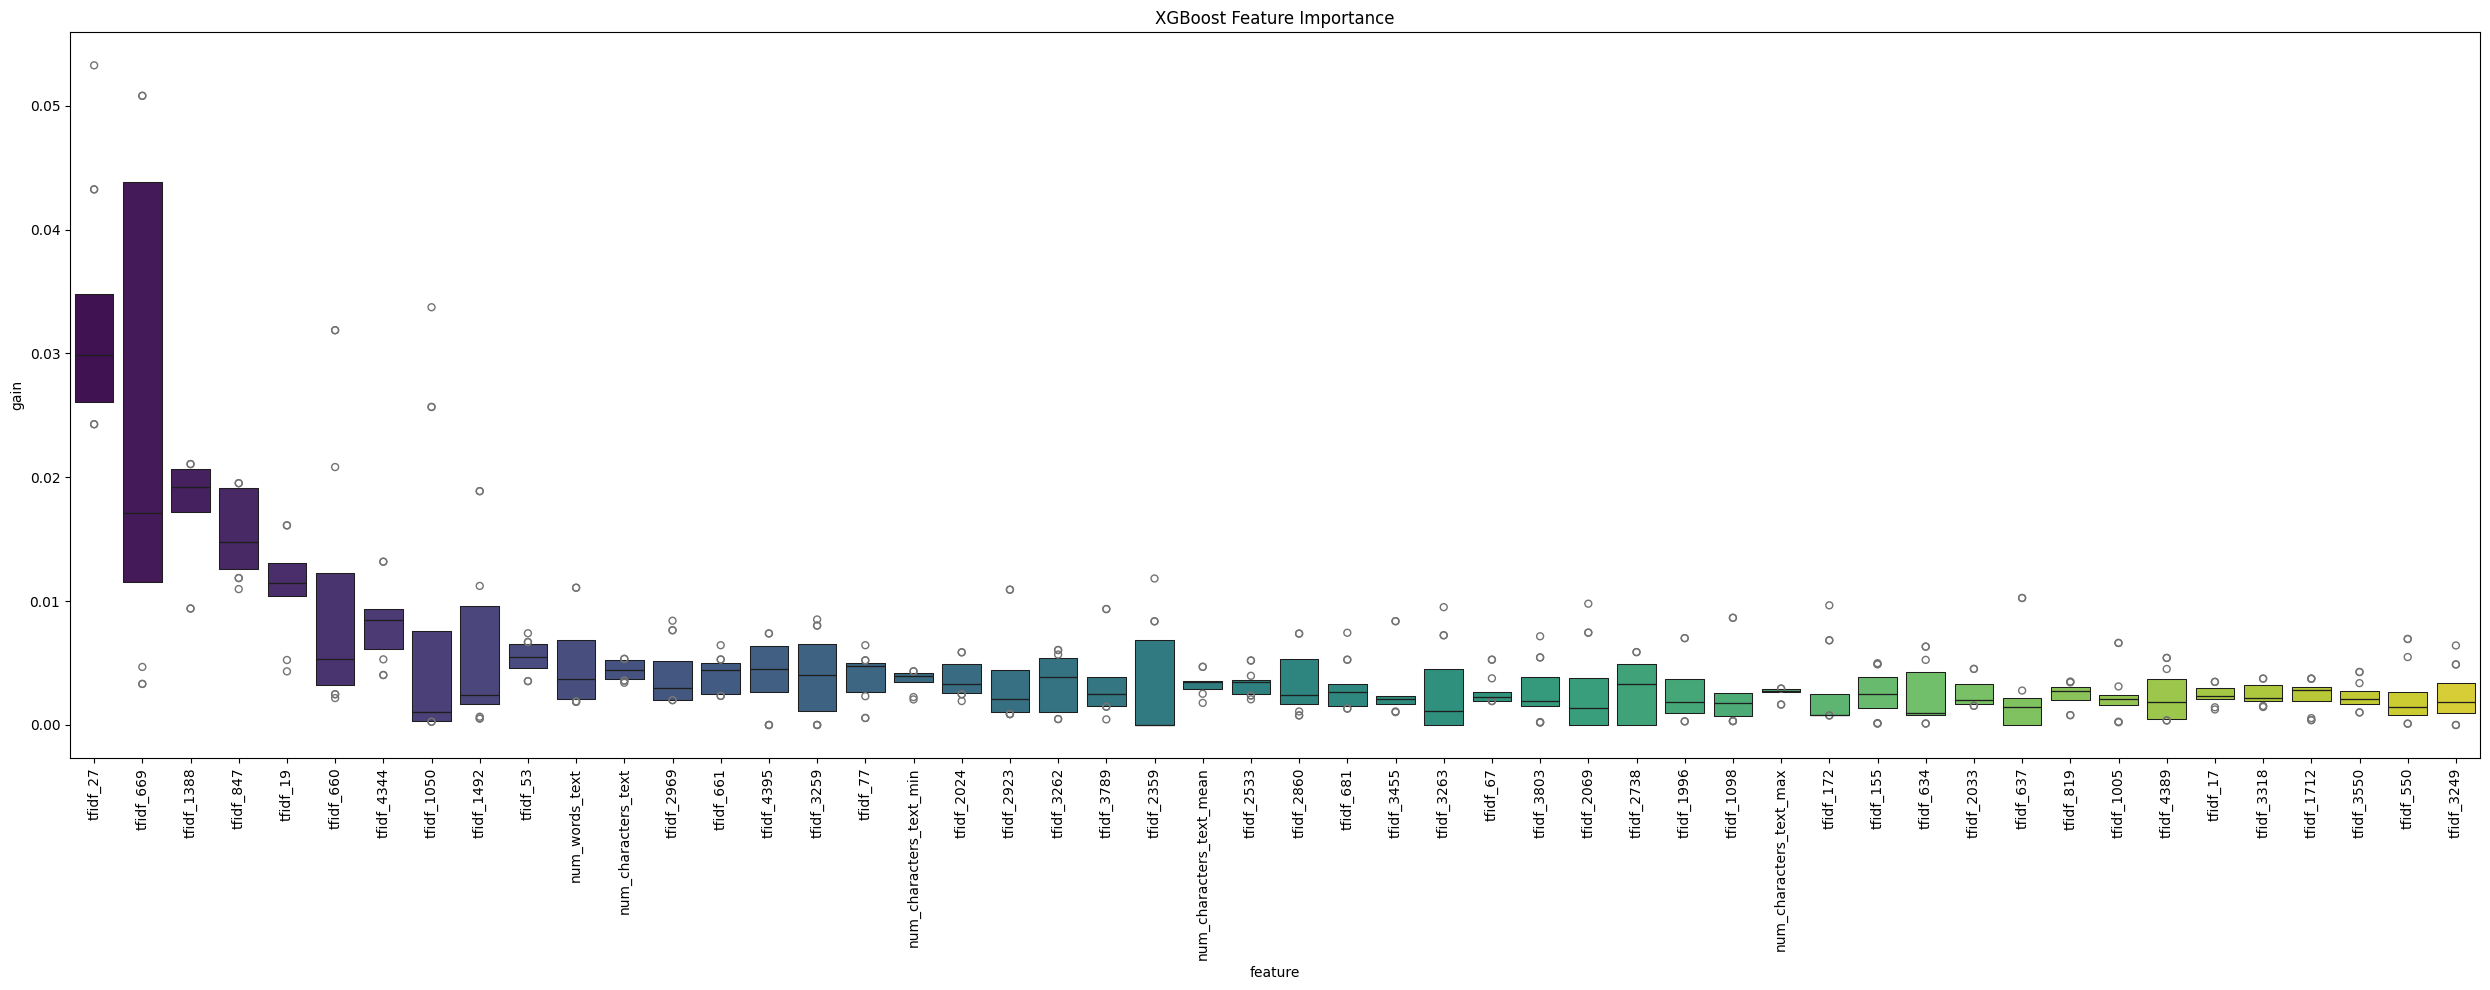

In [40]:
IMP_DF = pd.concat(imp_dfs, axis=0, ignore_index=True)
# 特徴量の平均重要度を計算して上位を選択
feature_importance = IMP_DF.groupby('feature').mean()[['gain']].sort_values('gain', ascending=False)
order = IMP_DF.groupby('feature').sum()[['gain']].sort_values('gain', ascending=False).index[:50]
plt.figure(figsize=(25, 10), tight_layout=True)
sns.boxenplot(data=IMP_DF,x='feature', y='gain', order=order,  palette='viridis')
plt.xticks(rotation=90)
plt.title(f"XGBoost Feature Importance")
plt.show()

In [53]:
import gc
for obj in gc.get_objects():
    if isinstance(obj, TfidfVectorizer):
        print("Found TfidfVectorizer object:", obj)
        tfidf_vectorizer = obj
        break

Found TfidfVectorizer object: TfidfVectorizer(ngram_range=(1, 2),
                preprocessor=<function <lambda> at 0x7f431e5ac400>,
                token_pattern=None,
                tokenizer=<function <lambda> at 0x7f431e5ac180>)


In [55]:
# 見つかったTF-IDFベクトライザーを使用
feature_names = tfidf_vectorizer.get_feature_names_out()

# 特徴量の総数を確認
print(f"Total number of features: {len(feature_names)}")

# tfidf_27が表す単語/フレーズを表示
if len(feature_names) > 27:
    print(f"tfidf_27 represents: {feature_names[27]}")
else:
    print(f"Index 27 is out of range. Total features: {len(feature_names)}")
# tfidf_669が表す単語/フレーズも確認
if len(feature_names) > 669:
    print(f"tfidf_669 represents: {feature_names[669]}")
else:
    print(f"Index 669 is out of range. Total features: {len(feature_names)}")

Total number of features: 4818
tfidf_27 represents: 
 *
tfidf_669 represents: * *


In [56]:
# 上位10個の特徴量インデックスとそれに対応する単語/フレーズを表示
important_indices = [27, 669, 188, 847, 134, 600, 344, 1050, 452, 531]  # グラフから読み取った上位の特徴量インデックス
for idx in important_indices:
    if idx < len(feature_names):
        print(f"tfidf_{idx} represents: {feature_names[idx]}")
    else:
        print(f"Index {idx} is out of range")

tfidf_27 represents: 
 *
tfidf_669 represents: * *
tfidf_188 represents:   p
tfidf_847 represents: .  
tfidf_134 represents:   :
tfidf_600 represents: ( i
tfidf_344 represents: # ,
tfidf_1050 represents: 1 .
tfidf_452 represents: & f
tfidf_531 represents: ' v


In [50]:
# バイナリ分類用にラベルを変換
train_df_binary = train_df.copy()

train_df_binary['label_binary'] = train_df_binary['label'].apply(lambda x: 0 if x == 0 else 1)

target_column_binary = 'label_binary'
config.num_classes_binary = 2 # クラス数を2に更新
config.xgb_params_binary = config.xgb_params.copy() # バイナリ分類用のパラメータ設定をコピーして作成
config.xgb_params_binary['objective'] = 'binary:logistic' # 目的関数を binary:logistic に変更
config.xgb_params_binary['num_class'] = 1 # binary:logistic の場合は num_class は不要
pprint(config.xgb_params_binary)

{'learning_rate': 0.1,
 'n_estimators': 2000,
 'num_class': 1,
 'objective': 'binary:logistic',
 'verbosity': 1}


★★★★ fold 1 (Binary) ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-logloss:0.57386	validation_1-logloss:0.60168
[1]	validation_0-logloss:0.52038	validation_1-logloss:0.57232
[2]	validation_0-logloss:0.47594	validation_1-logloss:0.55144
[3]	validation_0-logloss:0.43847	validation_1-logloss:0.53318
[4]	validation_0-logloss:0.40727	validation_1-logloss:0.52056
[5]	validation_0-logloss:0.37930	validation_1-logloss:0.50582
[6]	validation_0-logloss:0.35293	validation_1-logloss:0.49418
[7]	validation_0-logloss:0.33002	validation_1-logloss:0.48488
[8]	validation_0-logloss:0.31128	validation_1-logloss:0.48122
[9]	validation_0-logloss:0.29288	validation_1-logloss:0.47517
[10]	validation_0-logloss:0.27524	validation_1-logloss:0.46897
[11]	validation_0-logloss:0.26018	validation_1-logloss:0.46398
[12]	validation_0-logloss:0.24702	validation_1-logloss:0.45946
[13]	validation_0-logloss:0.23431	validation_1-logloss:0.45401
[14]	validation_0-logloss:0.22375	validation_1-logloss:0.44995
[15]	validat

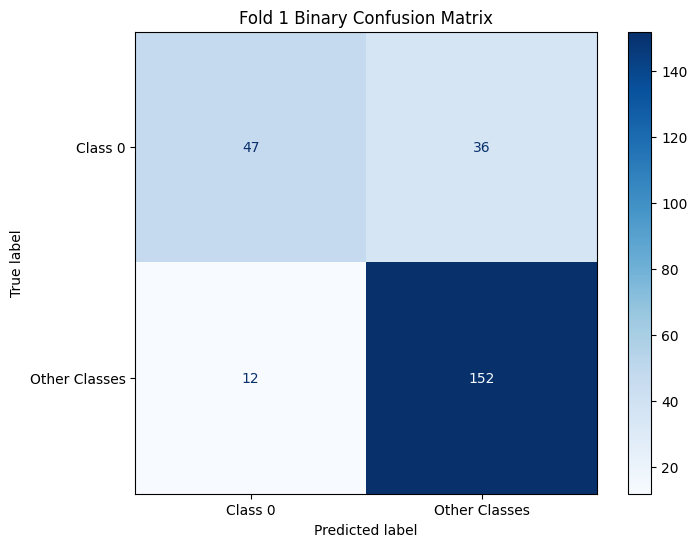

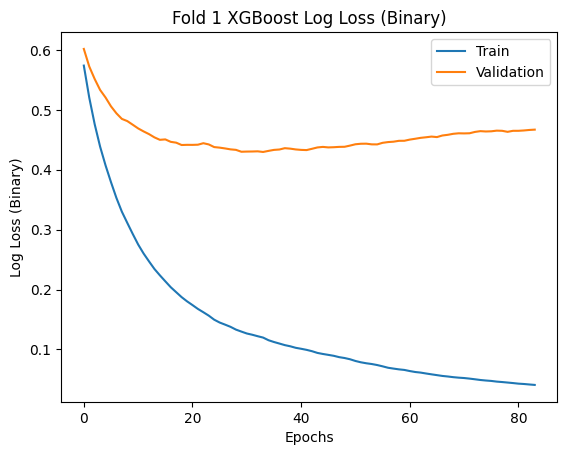

★★★★ fold 2 (Binary) ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-logloss:0.57537	validation_1-logloss:0.60231
[1]	validation_0-logloss:0.52537	validation_1-logloss:0.57391
[2]	validation_0-logloss:0.48082	validation_1-logloss:0.55350
[3]	validation_0-logloss:0.44235	validation_1-logloss:0.53597
[4]	validation_0-logloss:0.40963	validation_1-logloss:0.51839
[5]	validation_0-logloss:0.38046	validation_1-logloss:0.50505
[6]	validation_0-logloss:0.35522	validation_1-logloss:0.49156
[7]	validation_0-logloss:0.33131	validation_1-logloss:0.48018
[8]	validation_0-logloss:0.31120	validation_1-logloss:0.47259
[9]	validation_0-logloss:0.29130	validation_1-logloss:0.46615
[10]	validation_0-logloss:0.27359	validation_1-logloss:0.45801
[11]	validation_0-logloss:0.25837	validation_1-logloss:0.44694
[12]	validation_0-logloss:0.24501	validation_1-logloss:0.43925
[13]	validation_0-logloss:0.23235	validation_1-logloss:0.43297
[14]	validation_0-logloss:0.22149	validation_1-logloss:0.42857
[15]	validat

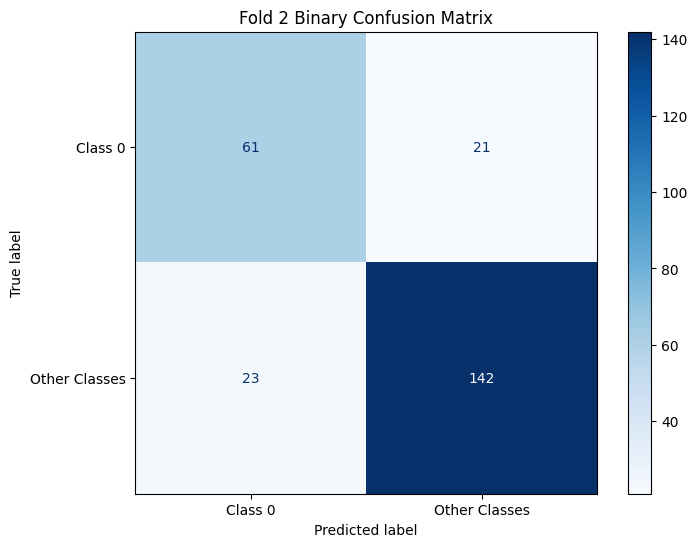

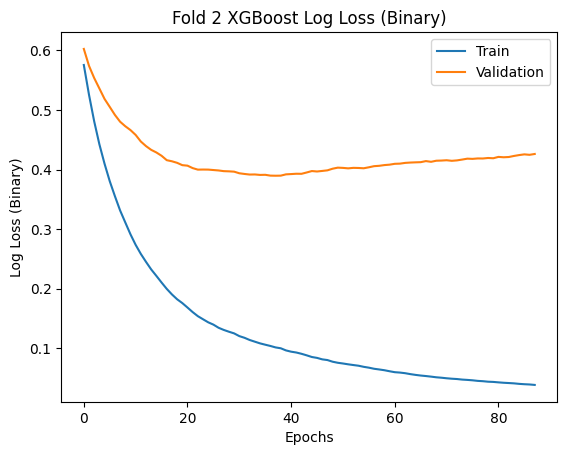

★★★★ fold 3 (Binary) ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-logloss:0.57726	validation_1-logloss:0.59923
[1]	validation_0-logloss:0.52803	validation_1-logloss:0.56829
[2]	validation_0-logloss:0.48812	validation_1-logloss:0.53649
[3]	validation_0-logloss:0.45230	validation_1-logloss:0.51922
[4]	validation_0-logloss:0.42088	validation_1-logloss:0.50569
[5]	validation_0-logloss:0.39348	validation_1-logloss:0.48757
[6]	validation_0-logloss:0.36968	validation_1-logloss:0.47864
[7]	validation_0-logloss:0.34434	validation_1-logloss:0.46949
[8]	validation_0-logloss:0.32461	validation_1-logloss:0.45898
[9]	validation_0-logloss:0.30655	validation_1-logloss:0.44768
[10]	validation_0-logloss:0.28928	validation_1-logloss:0.44095
[11]	validation_0-logloss:0.27482	validation_1-logloss:0.43167
[12]	validation_0-logloss:0.26140	validation_1-logloss:0.42413
[13]	validation_0-logloss:0.24892	validation_1-logloss:0.41794
[14]	validation_0-logloss:0.23720	validation_1-logloss:0.41201
[15]	validat

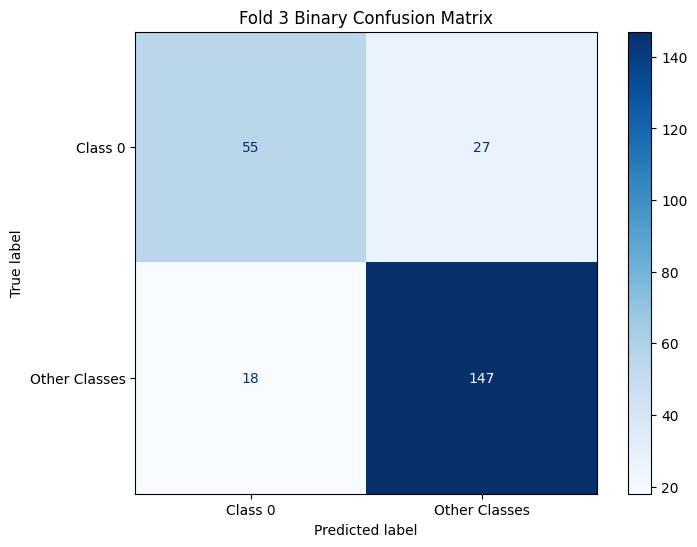

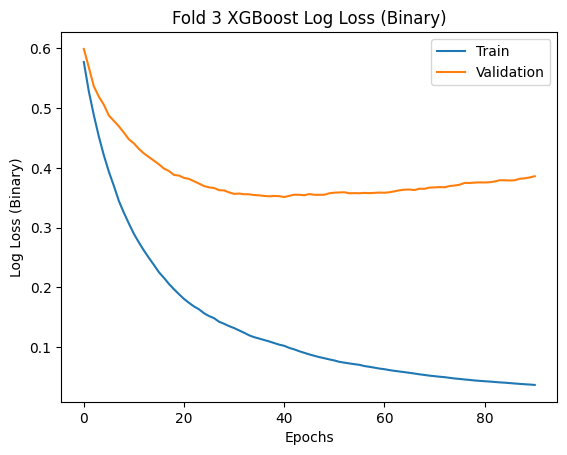

★★★★ fold 4 (Binary) ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-logloss:0.57745	validation_1-logloss:0.60275
[1]	validation_0-logloss:0.52737	validation_1-logloss:0.57061
[2]	validation_0-logloss:0.48553	validation_1-logloss:0.53858
[3]	validation_0-logloss:0.44831	validation_1-logloss:0.51764
[4]	validation_0-logloss:0.41593	validation_1-logloss:0.49661
[5]	validation_0-logloss:0.38593	validation_1-logloss:0.47848
[6]	validation_0-logloss:0.35986	validation_1-logloss:0.46695
[7]	validation_0-logloss:0.33642	validation_1-logloss:0.45414
[8]	validation_0-logloss:0.31623	validation_1-logloss:0.44314
[9]	validation_0-logloss:0.29791	validation_1-logloss:0.43795
[10]	validation_0-logloss:0.28103	validation_1-logloss:0.42885
[11]	validation_0-logloss:0.26619	validation_1-logloss:0.41927
[12]	validation_0-logloss:0.25223	validation_1-logloss:0.41361
[13]	validation_0-logloss:0.24062	validation_1-logloss:0.40516
[14]	validation_0-logloss:0.22862	validation_1-logloss:0.39711
[15]	validat

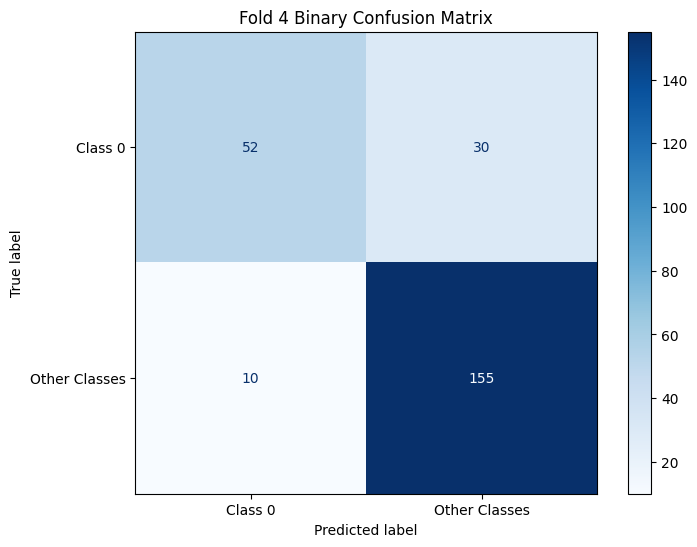

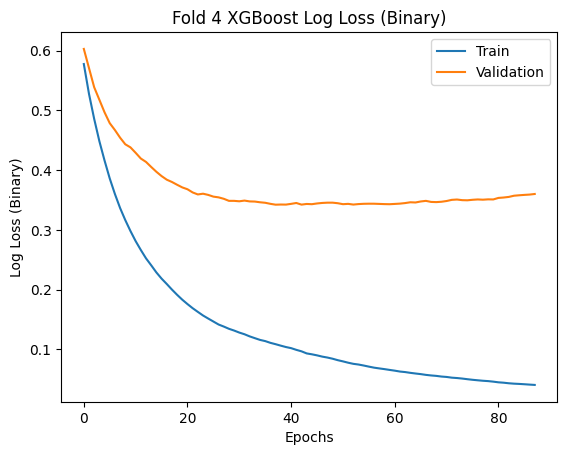

★★★★ fold 5 (Binary) ★★★★
X_train: 988, X_valid: 247
[0]	validation_0-logloss:0.57806	validation_1-logloss:0.59525
[1]	validation_0-logloss:0.52724	validation_1-logloss:0.56904
[2]	validation_0-logloss:0.48589	validation_1-logloss:0.54163
[3]	validation_0-logloss:0.44936	validation_1-logloss:0.52124
[4]	validation_0-logloss:0.41817	validation_1-logloss:0.50341
[5]	validation_0-logloss:0.38883	validation_1-logloss:0.48909
[6]	validation_0-logloss:0.36448	validation_1-logloss:0.47634
[7]	validation_0-logloss:0.34131	validation_1-logloss:0.46383
[8]	validation_0-logloss:0.31792	validation_1-logloss:0.44776
[9]	validation_0-logloss:0.29967	validation_1-logloss:0.43699
[10]	validation_0-logloss:0.28369	validation_1-logloss:0.42645
[11]	validation_0-logloss:0.26850	validation_1-logloss:0.41913
[12]	validation_0-logloss:0.25410	validation_1-logloss:0.41304
[13]	validation_0-logloss:0.24167	validation_1-logloss:0.40819
[14]	validation_0-logloss:0.23071	validation_1-logloss:0.40378
[15]	validat

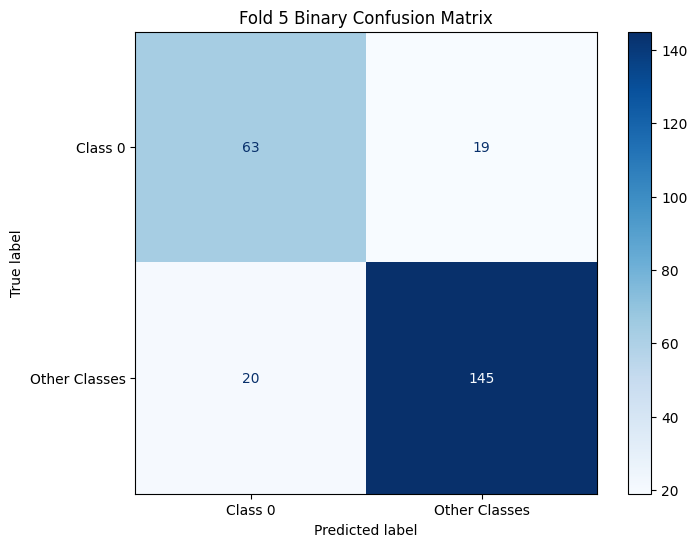

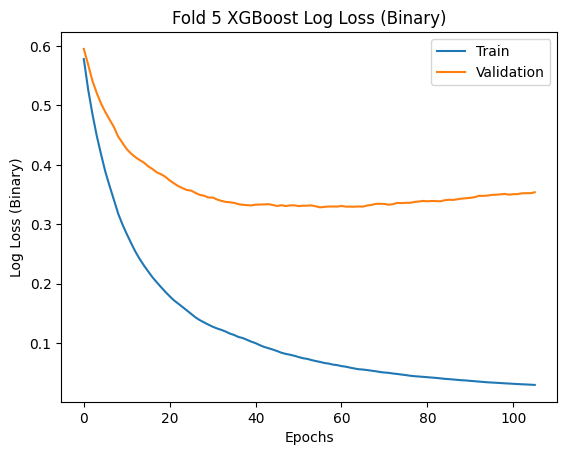

CV Score (Binary): 0.87279
全体の混同行列 (Binary):


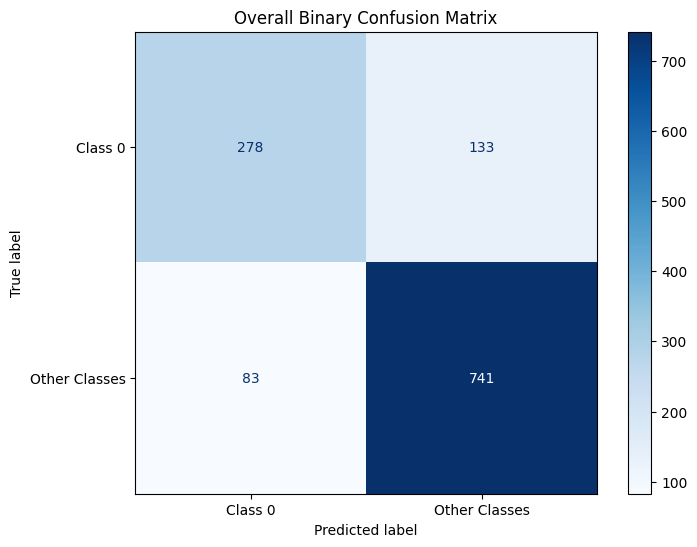

In [51]:
oof_prob_binary = np.zeros((len(train_df_binary), config.num_classes_binary)) # 出力次元を2に変更
imp_dfs_binary = []

for fold in range(config.n_fold):
    print(f'★★★★ fold {fold + 1} (Binary) ★★★★')
    seed_everything(config.seed)

    X_train = train_df_binary.query('fold != @fold + 1').reset_index(drop=True)
    X_valid = train_df_binary.query('fold == @fold + 1').reset_index(drop=True)
    valid_idx = train_df_binary.query('fold == @fold + 1').index.tolist()
    print(f'X_train: {len(X_train):,}, X_valid: {len(X_valid):,}')
    y_train = X_train[target_column_binary] # target_column をバイナリ分類用に変更
    X_train = X_train[feature_columns]

    y_valid = X_valid[target_column_binary] # target_column をバイナリ分類用に変更
    X_valid = X_valid[feature_columns]

    model_binary = XGBClassifier( # モデルも binary 用に変更
        **config.xgb_params_binary, # パラメータも binary 用に変更
        early_stopping_rounds=50
    )

    model_binary.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=True
    )

    pred_val_binary = model_binary.predict_proba(X_valid, iteration_range=(0, model_binary.best_iteration + 1))
    oof_prob_binary[valid_idx] += pred_val_binary
    valid_score = f1_score( # 評価指標は f1_score をそのまま使用可能 (binary にも対応)
        y_valid,
        pred_val_binary.argmax(axis=1), # binary なので argmax(axis=1) でクラス予測
        average='binary' # binary 分類なので average='binary' を指定
    )
    print(f"Fold {fold + 1} | Valid_score (Binary): {valid_score:.5f}")
    print(f"Fold {fold + 1} (Binary) の混同行列:")
    cm_binary = plot_confusion_matrix_binary(y_valid, pred_val_binary.argmax(axis=1), title=f'Fold {fold + 1} Binary Confusion Matrix') # 混同行列も binary 用の関数を使用

    importances = pd.DataFrame()
    importances["feature"] = feature_columns
    importances["gain"] = model_binary.feature_importances_
    importances["fold"] = fold + 1
    imp_dfs_binary.append(importances)

    model_binary.save_model(f'./xgboost_binary_fold_{fold + 1}.json')
    results = model_binary.evals_result()
    epochs = len(results['validation_0']['logloss']) # binary 分類なので metric は logloss
    x_axis = range(0, epochs)

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train') # metric は logloss
    ax.plot(x_axis, results['validation_1']['logloss'], label='Validation') # metric は logloss
    ax.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss (Binary)') # y軸ラベルを修正
    plt.title(f'Fold {fold + 1} XGBoost Log Loss (Binary)') # タイトルを修正
    plt.show()


F1Score_binary = f1_score(train_df_binary['label_binary'], np.argmax(oof_prob_binary, axis=1), average='binary') # 評価指標も binary 用に変更
print(f'CV Score (Binary): {F1Score_binary:.5f}')

y_true_binary = train_df_binary[target_column_binary]
y_pred_binary = np.argmax(oof_prob_binary, axis=1)

print("全体の混同行列 (Binary):")
cm_all_binary = plot_confusion_matrix_binary(y_true_binary, y_pred_binary, title='Overall Binary Confusion Matrix') # 混同行列も binary 用の関数を使用

In [ ]:
sub_df['label'] = np.argmax(test_prob, axis=1)
sub_df.to_csv(OUTPUT_DIR / f'{config.exp_name}_{F1Score:.5f}_submission.csv', index=False)